# Task 4.4 Supervised Learning - Classification and hyperparameter tuning

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
plt.rcParams["figure.figsize"]=(4,3)

In [3]:
cox2=pd.read_csv("cox2.csv")
cox2

,QikProp_.stars,QikProp_.amine,QikProp_.acid,QikProp_.rotor,QikProp_.rctvFG,QikProp_CNS,QikProp_MW,QikProp_dipole,QikProp_SASA,QikProp_FOSA,...,moe2D_vsa_acc,moe2D_vsa_don,moe2D_vsa_hyd,moe2D_vsa_other,moe2D_vsa_pol,moe2D_weinerPath,moe2D_weinerPol,moe2D_zagreb,IC50,cox2Class
0,1,0,0,1,0,0,358.882,7.645,635.022,273.363,...,32.02,0.00,268.2,6.513,0.00,1340,37,138,0.001,Inactive
1,0,0,0,2,0,-1,359.870,7.959,622.548,189.930,...,32.02,20.14,236.8,10.110,0.00,1340,37,138,0.001,Inactive
2,0,0,0,3,0,-1,355.451,7.500,610.972,268.526,...,34.52,20.14,238.4,18.560,0.00,1524,39,142,0.001,Inactive
3,1,0,0,2,0,-1,393.423,9.342,651.852,190.772,...,32.02,20.14,249.7,10.110,0.00,1898,43,156,0.001,Inactive
4,1,0,0,2,0,-1,394.315,9.409,637.688,189.933,...,32.02,20.14,255.1,10.110,0.00,1486,40,144,0.001,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2,0,0,1,0,0,461.928,6.419,701.162,83.433,...,37.70,0.00,316.0,21.890,0.00,2373,50,164,100.000,Active
458,1,0,0,1,0,0,316.349,8.097,537.398,83.436,...,32.02,0.00,209.9,13.210,18.84,1099,33,118,100.000,Active
459,2,0,0,1,0,0,384.348,6.748,583.611,84.427,...,32.02,0.00,234.4,19.910,18.84,1626,42,142,100.000,Active
460,0,0,0,3,0,0,356.414,8.417,633.843,200.694,...,41.44,0.00,275.4,13.210,0.00,1529,38,132,100.000,Active


In [ ]:
# Aktivitätsklasse berechnen anhand von Cutoff: 2^2.5 ≈ 5.6568
cutoff = 2 ** 2.5  # ~5.6568
cox2 = cox2[cox2['IC50'].notna()]  # Entferne Zeilen mit fehlendem IC50
cox2['Activity'] = np.where(cox2['IC50'] <= cutoff, 'active', 'inactive')

In [ ]:

y = cox2['cox2Class']

#Note-AI: ChatGPT hat mir den Tipp gegeben diese spalte zu entfernen
#Feature-Matrix: entferne Zielspalte und ggf. IC50 (falls vorhanden)

X = cox2.drop(columns=['cox2Class', 'IC50'], errors='ignore')
X = X.select_dtypes(include=[np.number])  # nur numerische Spalten behalten

In [ ]:
# Prüfen, ob in X noch nicht-numerische Spalten sind (kann man auch löschen)
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print("Nicht-numerische Spalten im Feature-Set:\n", non_numeric_cols)

Nicht-numerische Spalten im Feature-Set:
 Index([], dtype='object')


In [ ]:
# Datensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
#  Pipeline + Hyperparameter-Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

#Note-AI: Hier habe ich mit von ChatGPT "common" Werte ausgebenlassen, da ich mir unsicher war welche zu nutzen sind
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__n_estimators': [100, 200]},
             scoring='accuracy')

In [47]:
# Modellbewertung
print("Beste Parameter:", grid_search.best_params_)
print("Beste Kreuzvalidierungsgenauigkeit: {:.4f}".format(grid_search.best_score_))

Beste Parameter: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__n_estimators': 200}
Beste Kreuzvalidierungsgenauigkeit: 0.8298


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
# Note AI: Hierbei hatte ich Hilfevon ChatGPT
# Zielklasse ist "Active" → Index herausfinden
active_index = list(grid_search.classes_).index('Active')

# Wahrscheinlichkeiten für "Active"
y_train_proba = best_model.predict_proba(X_train)[:, active_index]

# Zielvektor binarisiert
y_train_bin = (y_train == 'Active').astype(int)

# AUC berechnen
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train_bin, y_train_proba)
print(f"Train AUC: {train_auc:.3f}")

Train AUC: 1.000


Inerpretation: Overfitting?

In [41]:
y_test_bin = (y_test == 'Active').astype(int)
y_test_proba = best_model.predict_proba(X_test)[:, active_index]
test_auc = roc_auc_score(y_test_bin, y_test_proba)
print(f"Test AUC: {test_auc:.3f}")

Test AUC: 0.831


In [ ]:

#  Vorhersage auf Testdaten
y_pred = grid_search.predict(X_test)

In [49]:
#  Test-Metriken
print("\nTestgenauigkeit: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("\nKlassifikationsbericht:\n", classification_report(y_test, y_pred))


Testgenauigkeit: 0.8362

Klassifikationsbericht:
               precision    recall  f1-score   support

      Active       0.67      0.35      0.46        23
    Inactive       0.86      0.96      0.90        93

    accuracy                           0.84       116
   macro avg       0.76      0.65      0.68       116
weighted avg       0.82      0.84      0.82       116



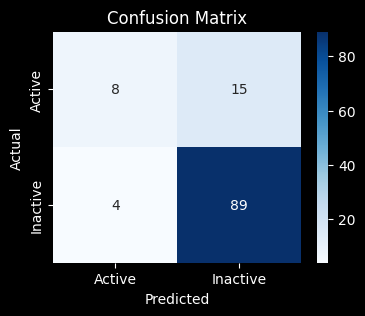

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Wichtigste Merkmale anzeigen
best_model = grid_search.best_estimator_
importances = best_model.named_steps['clf'].feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 10 wichtigste Merkmale:\n", feature_importance.head(10))


Top 10 wichtigste Merkmale:
 QikProp_QPlogS          0.013866
moe2D_SMR_VSA2          0.013047
moe2D_logS              0.013037
QikProp_QPlogPo.w       0.012285
moe2D_PEOE_VSA_FPPOS    0.012134
moe2D_BCUT_PEOE_2       0.012013
moe2D_bpol              0.011917
moe2D_SMR_VSA0          0.011678
moe2D_SlogP_VSA9        0.011110
QikProp_IP.eV.          0.010929
dtype: float64


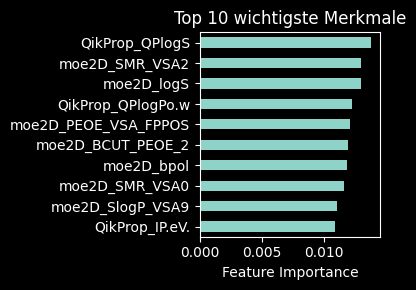

In [25]:
# Barplot der wichtigsten Merkmale
feature_importance.head(10).plot(kind='barh')
plt.title('Top 10 wichtigste Merkmale')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

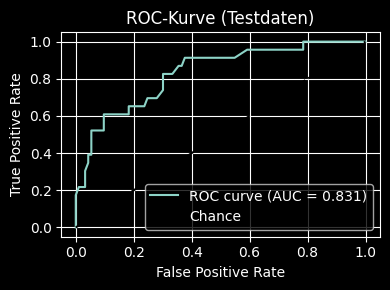

In [ ]:
#Note-AI: Diesen Plot habe ich mitHilfe von ChatGPT erstellt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

# 1. Zielklasse "Active" = Index in predict_proba()
active_index = list(grid_search.classes_).index('Active')

# 2. Wahrscheinlichkeiten für "Active" aus dem Modell holen
y_test_proba = best_model.predict_proba(X_test)[:, active_index]

# 3. Ziel binär kodieren: Active = 1, Inactive = 0
y_test_bin = (y_test == 'Active').astype(int)

# 4. ROC-Kurve berechnen
fpr, tpr, _ = roc_curve(y_test_bin, y_test_proba)
roc_auc = auc(fpr, tpr)

# 5. Plotten
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve (Testdaten)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

Interpretation: Gutes Modell, da es aktive und inaktive Moleküle gut trennt